In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload 
%autoreload 2

import scipy.stats
import numpy as np
import inla


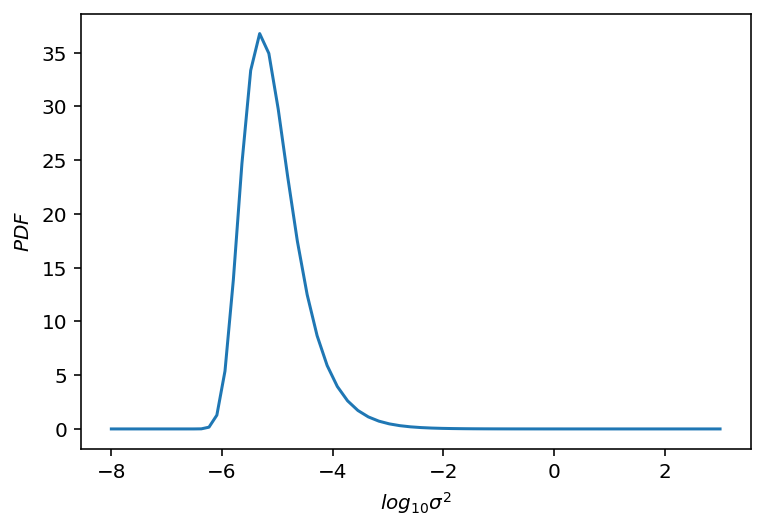

exact CDF:  0.00922569143991095
numerical integration CDF:  0.009225691439910979
error:  2.7755575615628914e-17


In [2]:

def log_gauss_rule(N, a, b):
    A = np.log(a)
    B = np.log(b)
    p, w = inla.gauss_rule(N, a=A, b=B)
    pexp = np.exp(p)
    wexp = np.exp(p) * w
    return (pexp, wexp)

a = 1e-8
b = 1e3
pexp, wexp = log_gauss_rule(90, a, b)
alpha = 0.0005
beta = 0.000005
f = scipy.stats.invgamma.pdf(pexp, alpha, scale=beta)
exact = scipy.stats.invgamma.cdf(b, alpha, scale=beta) - scipy.stats.invgamma.cdf(a, alpha, scale=beta)
est = np.sum(f * wexp)
plt.plot(np.log(pexp) / np.log(10), f)
plt.xlabel('$log_{10}\sigma^2$')
plt.ylabel('$PDF$')
plt.show()
print('exact CDF: ', exact),
print('numerical integration CDF: ', est)
print('error: ', est - exact)
sigma2_rule = (pexp, wexp)

# The model and simulations.

To match with the INLA notation, the $\theta$ parameter for Berry et al 2013 is called $x$ here. Also, Berry uses:
\begin{equation}
\tilde{x} = logit(p) - logit(p_1)
\end{equation}
whereas we use:
\begin{equation}
x = logit(p) = \tilde{x} + logit(p_1)
\end{equation}

In [3]:
p0 = np.full(4, 0.1) # rate of response below this is the null hypothesis
p1 = np.full(4, 0.3) # rate of response above this is the alternative hypothesis.
# rate of response > p0 and < p1 is gray area.
p0_x = scipy.special.logit(p0)

pmid = (p0 + p1) / 2
pmid_x = scipy.special.logit(pmid)

 # final evaluation criterion 
 # accept the alternative hypo if Pr(p[i] > p0|data) > pfinal_thresh[i]
pfinal_thresh = np.full(4, 0.85)

# early stopping criterion
pmid_accept = 0.9
pmid_fail = 0.05

null_x_berry = np.log(p0 / (1 - p0)) - np.log(p1 / (1 - p1))
null_x = np.log(p0 / (1 - p0))
prior_mu_mean = null_x[0]

def berry_prior(theta):
    mu = theta[..., 0]
    mu_prior = scipy.stats.norm.logpdf(mu, prior_mu_mean, 100)

    sigma2 = theta[..., 1]
    alpha = 0.0005
    beta = 0.000005
    sigma2_prior = scipy.stats.invgamma.logpdf(sigma2, alpha, scale=beta)
    return mu_prior + sigma2_prior

In [4]:
# I got this data by deconstructing the graphs in in Figure 1 of Berry et al 2013.
n_i = np.array([[i] * 4 for i in [10,15,20,25,30,35]])
y_i = np.array([[1, 6, 3, 3], [3, 8, 5, 4], [6,9,7,5], [7,10,8,7], [8,10,9,8], [11, 11, 10, 9]])
data = np.stack((y_i, n_i), axis=2)

model = inla.binomial_hierarchical()
model.log_prior = berry_prior

mu_rule = inla.gauss_rule(201, -5, 3)

# Dirty Bayes for the Berry model

## Notation
* $d$ is the number of arms in the trial
* $\hat{I}$ is the sample information matrix.
* $\mathbf{y}$ is the *vector* probability-space data.
* $\mathbf{n}$ is the *vector* number of patients per arm.
* $\mathbf{\theta}$ is the *vector* logit-space true parameters
* $\hat{\mathbf{\theta}}$ is the *vector* logit-space observed values
* $\mu$ is the mean of the sharing distribution
* $\sigma$ is the standard deviation of the sharing distribution
* $\mu_0 = -1.34$ is the mean of the $\mu$ prior.
* $S = 10$ is the std dev of the $\mu$ prior.

## The basic model
\begin{align}
\mathbf{y}\mathbf{n} &\sim Binomial( \mathbf{\theta}, \mathbf{n})\\
\mathbf{\theta} &\sim N(\mu, \sigma^2)\\
\mu &\sim N(\mu_0, S^2)\\
\sigma^2 &\sim InvGamma(0.0005, 0.000005)\\

P(y, \theta, \sigma^2) &= P(\sigma^2) P(\theta|\sigma^2) P(y|\theta)
\end{align}

## Section 1: Approximating the posterior conditional on hyperparameters

### Step #1, exact, integrate out $\mu$, just use normal distribution conjugacy

\begin{align}
P(\mu) &= N(\mu_0, S^2)\\
P(\theta|\mu, \sigma^2) &= N(\mu_0, \sigma^2)\\
P(\theta|\sigma^2) &= P(\theta|\mu_0, \sigma^2, S^2) =  N(\mu_0, \sigma^2 I + S^2 J)
\end{align}

where J is the matrix of all 1s (everywhere, not just the diagonal?).

### Step #2, the important approximation!! Binomial asymptotically is Normal 

\begin{align}
\mathbf{y} \sim N(\mathbf{\theta}, I^{-1})
\end{align}

### Step #3, introduce data to approximate likelihood:

\begin{align}
I^{-1} \approx \hat{I}^{-1} = \hat{p} (1 - \hat{p}) / n\\
P(y|\theta) = N(\mathbf{\theta}, I^{-1}) \approx N(\hat{\mathbf{\theta}}, \hat{I}^{-1})\\
\end{align}

### Step #4, combine the two Gaussians $P(\theta|y)$ and $P(\theta|\sigma^2)$:

\begin{align}
P(\theta|y,\sigma^2) = \frac{P(\theta|\sigma^2)P(y|\theta)}{P(y|\sigma^2)}
\end{align}

Using Gaussian posterior conjugacy: 
\begin{align}
\theta|y, \sigma^2 \sim N(\mu_d, \Sigma_d)\\
\mu_d = ...\\
\Sigma_d = ...\\
\end{align}


## Section 2: Integration over hyperparameters
### Step #5: integrate out $\sigma^2$

\begin{align}
P(\theta|y) = \int P(\theta| y, \sigma^2)P(\sigma^2|y) d\sigma^2
\end{align}

### Step #6: manipulate $\sigma^2$ posterior

By definition of conditional prob:
\begin{align}
P(\sigma^2|y) = \frac{P(\sigma^2, y)}{P(y)}
\end{align}

### Step #7: computing the joint distribution $P(\sigma^2, y)$

\begin{align}
P(\sigma^2, y) &= P(\sigma^2)P(y|\sigma^2)\\
y|\sigma^2 &\sim N(\mu, \hat{I}^{-1} + \Sigma_{\sigma^2})
\end{align}
Also, recall the prior:
\begin{align}
\sigma^2 &\sim InvGamma(0.0005, 0.000005)\\
\end{align}

### Step #8: compute $P(y)$ posterior

Once we have computed the joint probability $P(\sigma^2, y)$, the denominator/marginal/data-prior $P(y)$ can be easily computed by numerically integrating over $\sigma^2$.

### Step #9: actually do the integral from step #5.

Because this integral is done numerically, we now have a mixture of Gaussians. The mean and variance of a weighted mixture of gaussians is a well-known formula: INSERT FORMULA HERE.


In [13]:
def fast_invert(S, d):
    for k in range(len(d)):
        offset = (d[k] / (1 + d[k] * S[k, k])) * np.outer(
            S[k],
            S[..., k],
        )  # I wonder how to cheaply represent this outer? but in C++ it should be just a trivial for-loop anyway
        S = S - offset
    return S

def calc_posterior_x(
    sigma_sq: float,
    mu_sig_sq: float,
    sample_I,
    thetahat,
    mu_0,
    d
):
    assert len(sigma_sq) == 1, sigma_sq
    S_0 = np.diag(np.repeat(sigma_sq, d)) + mu_sig_sq
    # V_0 = solve(S_0) #but because this is a known case of the form aI + bJ, we can use the explicit
    # inverse formula, given by: 1/a I - J*(b/(a(a+db)))
    V_0 = np.diag(np.repeat(1 / sigma_sq, d)) - (mu_sig_sq / sigma_sq) / (
        sigma_sq + d * mu_sig_sq
    )
    Sigma_posterior = fast_invert(S_0, sample_I)
    # precision_posterior = V_0 + np.diag(sample_I)
    # Sigma_posterior = np.linalg.inv(precision_posterior)
    mu_posterior = Sigma_posterior @ (sample_I * thetahat + V_0 @ mu_0)
    return mu_posterior, np.diag(Sigma_posterior)

def calc_dirty_bayes(y_i, n_i):
    N = 6
    d = 4
    phat = y_i[:, :] / n_i[:, :]
    thetahat = scipy.special.logit(phat)
    sample_I = n_i[:, :] * phat * (1 - phat)  # diag(n*phat*(1-phat))
    mu_0 = np.full_like(phat, -1.34)
    mu_sig_sq = 100

    mu_posterior = np.empty((N, sigma2_rule[0].shape[0], d))
    sigma2_posterior = np.empty((N, sigma2_rule[0].shape[0], d))
    joint_sigma2_y = np.empty((N, sigma2_rule[0].shape[0], d))
    for i in range(N):
        for j in range(sigma2_rule[0].shape[0]):
            # Step 1-4: see above.
            sig2 = sigma2_rule[0][j]
            (
                mu_posterior[i, j],
                sigma2_posterior[i, j],
            ) = calc_posterior_x(
                np.array([sig2]),
                np.array([mu_sig_sq]),
                sample_I[i],
                thetahat[i],
                mu_0[i],
                d,
            )
            # Step 6/7
            prior = scipy.stats.invgamma.pdf(sig2, 0.0005, scale=0.000005)
            y_given_sig2 = scipy.stats.multivariate_normal.pdf(
                thetahat[i],
                mu_0[i],
                (
                    np.diag(sample_I[i] ** -1)
                    + np.diag(np.repeat(sig2, d))
                    + mu_sig_sq
                ),
            )
            joint_sigma2_y[i, j] = prior * y_given_sig2

    # Step 8
    py = np.sum(joint_sigma2_y * sigma2_rule[1][None, :, None], axis=1)
    sigma2_given_y = joint_sigma2_y / py[:, None, :]

    # Step 9: 
    weights = sigma2_given_y * sigma2_rule[1][None, :, None]
    mu_db = np.sum(mu_posterior * weights, axis=1)
    T = (mu_posterior - mu_db[:, None, :]) ** 2 + sigma2_posterior
    sigma2_db = np.sum(T * weights, axis=1)
    sigma_db = np.sqrt(sigma2_db)
    return mu_db, sigma_db

In [14]:
post_theta, report = inla.calc_posterior_theta(model, data, (mu_rule, sigma2_rule))
mu_inla, sigma_inla = inla.calc_posterior_x(post_theta, report)

In [15]:
mu_db, sigma_db = calc_dirty_bayes(y_i, n_i) 

$$1.0 = \sum_i f(x_i) w_i$$

"CDF" is:
* $f(x_i)$

"cumulative prob" is:
* $f(x_i) * w_i$

the cdf would be... 
$$ F(x_j) = \sum_{i < j} f(x_i) w_i$$ 

In [16]:
def figure1_plot(title, data, mu_post, sigma_post):
    # expit(mu_post) is the posterior estimate of the mean probability.
    p_post = scipy.special.expit(mu_post)

    # two sigma confidence intervals transformed from logit to probability space.
    cilow = scipy.special.expit(mu_post - 2 * sigma_post)
    cihigh = scipy.special.expit(mu_post + 2 * sigma_post)

    y = data[:, :, 0]
    n = data[:, :, 1]

    # The simple ratio of success to samples. Binomial "p".
    raw_ratio = y / n
    p_success = np.empty_like(mu_post)

    # early stopping criterion
    p_success[:5] = 1.0 - scipy.stats.norm.cdf(pmid_x, mu_post[:5], sigma_post[:5])
    # final success criterion
    p_success[5] = 1.0 - scipy.stats.norm.cdf(p0_x, mu_post[5], sigma_post[5])


    fig = plt.figure(figsize=(15, 10))
    plt.suptitle(title)
    outergs = fig.add_gridspec(2, 3, hspace=0.3)
    for i in range(data.shape[0]):

        innergs = outergs[i].subgridspec(
            2, 1, wspace=0, hspace=0, height_ratios=[0.7, 0.3]
        )

        plt.subplot(innergs[0])
        plt.plot(np.arange(4), raw_ratio[i], "kx")
        plt.plot(np.arange(4), p_post[i], "ko", mfc="none")
        plt.plot(np.arange(4), p_success[i], "k ", marker=(8, 2, 0))

        plt.vlines(np.arange(4), cilow[i], cihigh[i], color="k", linewidth=1.0)

        if i < 5:
            plt.title(f"Interim Analysis {i+1}")
            plt.hlines([pmid_fail, pmid_accept], -1, 4, colors=["k"], linestyles=["--"])
            plt.text(-0.1, 0.91, "Early Success", fontsize=7)
            plt.text(2.4, 0.06, "Early Futility", fontsize=7)
        else:
            plt.title("Final Analysis")
            plt.hlines([pfinal_thresh[0]], -1, 4, colors=["k"], linestyles=["--"])
            plt.text(-0.1, 0.86, "Final Success", fontsize=7)

        plt.xlim([-0.3, 3.3])
        plt.ylim([0.0, 1.05])
        plt.yticks(np.linspace(0.0, 1.0, 6))
        plt.xlabel("Group")
        plt.ylabel("Probability")

        plt.subplot(innergs[1])
        plt.bar(
            [0, 1, 2, 3],
            n[i],
            tick_label=[str(i) for i in range(4)],
            color=(0.6, 0.6, 0.6, 1.0),
            edgecolor="k",
            zorder=0,
        )
        plt.bar(
            [0, 1, 2, 3],
            y[i],
            color=(0.6, 0.6, 0.6, 1.0),
            hatch="////",
            edgecolor="w",
            lw=1.0,
            zorder=1,
        )
        #         # draw hatch
        # ax1.bar(range(1, 5), range(1, 5), color='none', edgecolor='red', hatch="/", lw=1., zorder = 0)
        # # draw edge
        plt.bar([0, 1, 2, 3], y[i], color="none", edgecolor="k", zorder=2)
        ticks = np.arange(0, 36, 5)
        plt.yticks(ticks, [str(i) if i % 10 == 0 else "" for i in ticks])
        plt.xticks(np.arange(4), ['1', '2', '3', '4'])
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
        plt.xlabel("Group")
        plt.ylabel("N")

    plt.show()


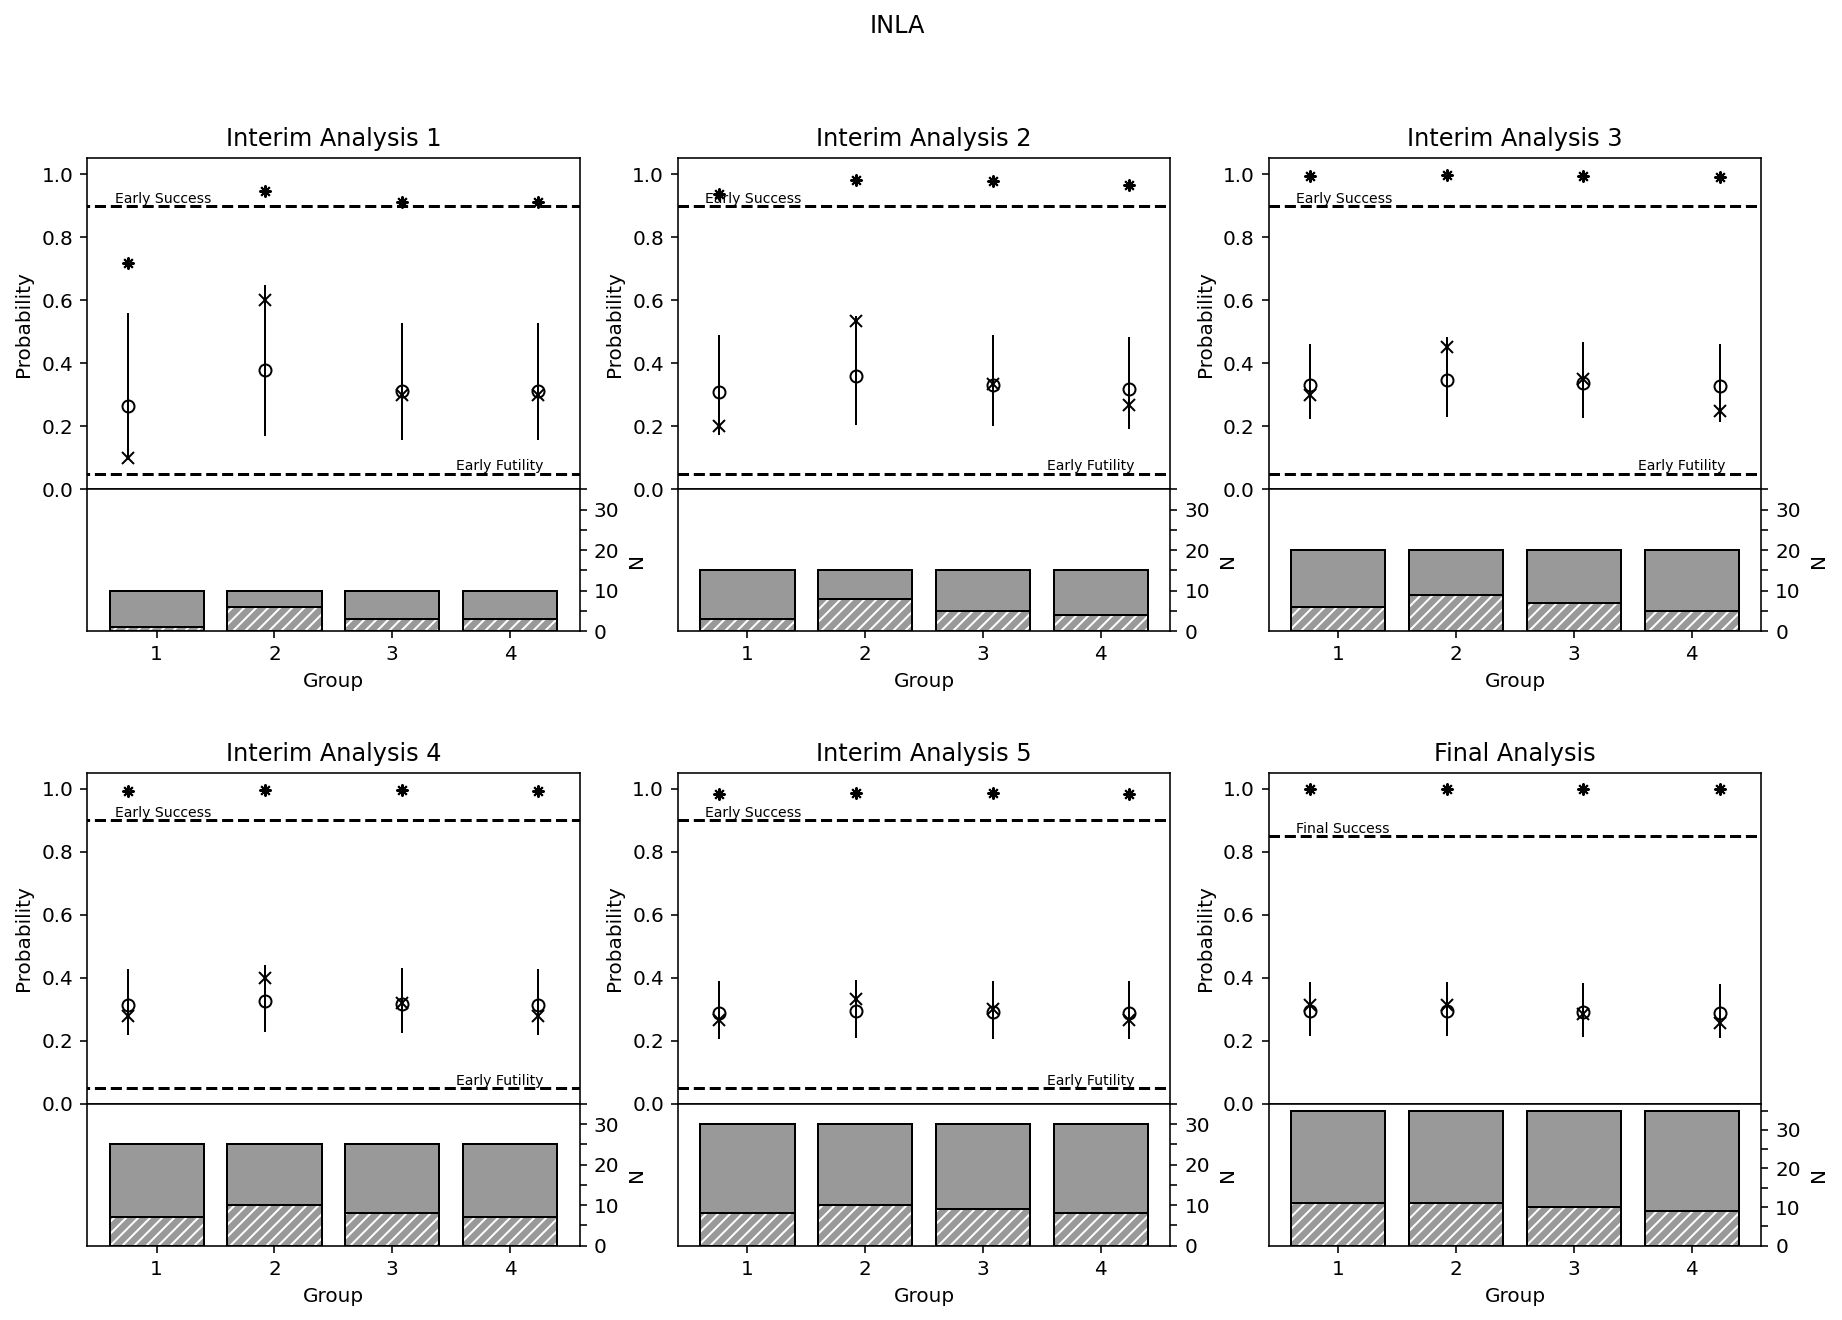

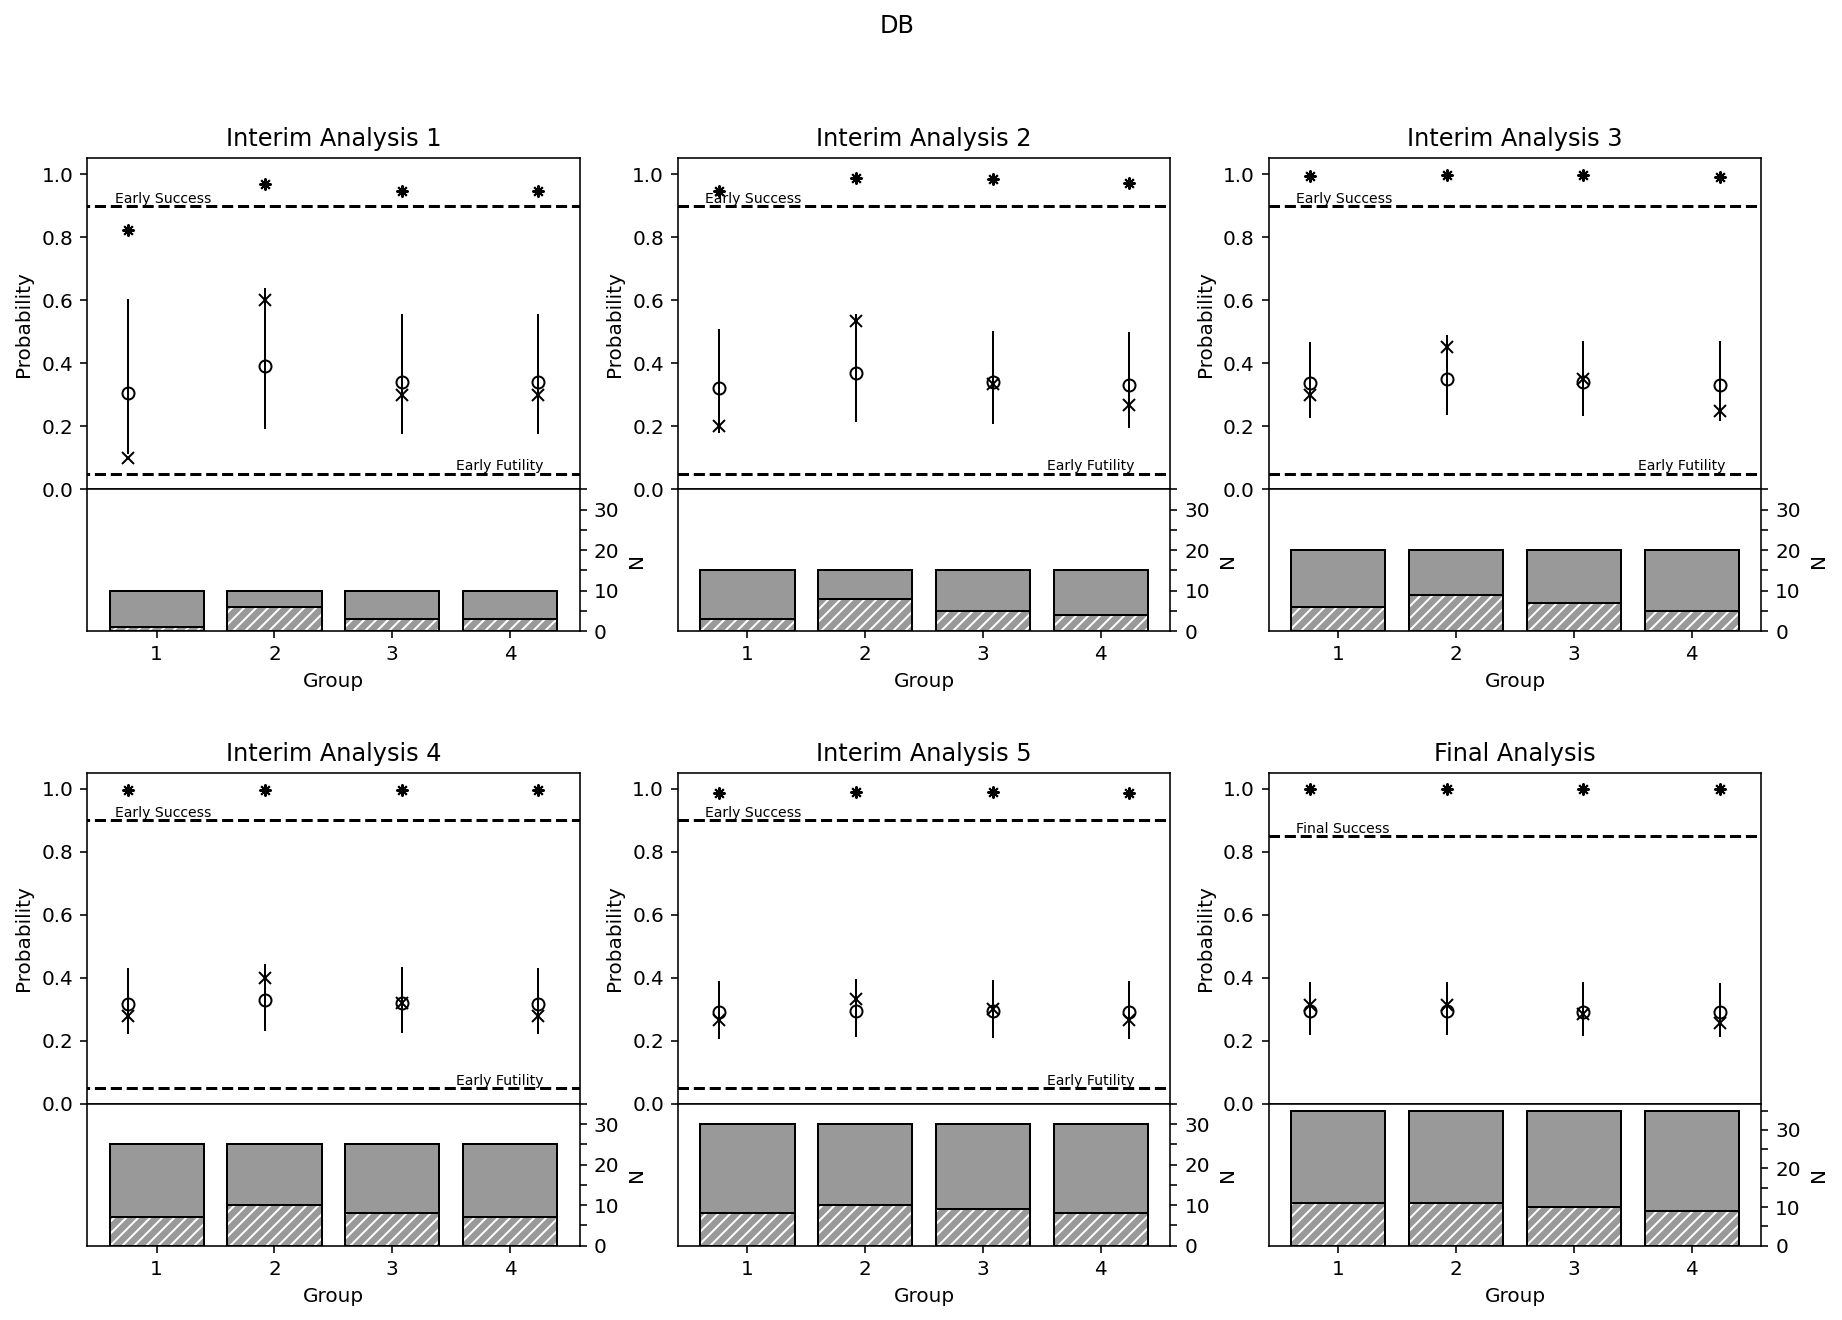

In [17]:
figure1_plot('INLA', data, mu_inla, sigma_inla)
figure1_plot('DB', data, mu_db, sigma_db)

# Figure 2

In [18]:

# I got this data by deconstructing the graphs in in Figure 1 of Berry et al 2013.
n_i2 = np.array([[10, 10, 10, 10], [15, 15, 15, 15], [20, 20, 20, 20], [20, 20, 25, 25], [20, 20, 30, 30], [20, 20, 35, 35]])
y_i2 = np.array([[0, 1, 3, 3], [0, 1, 4, 5], [0, 1, 6, 6], [0, 1, 6, 7], [0, 1, 7, 8], [0, 1, 9, 10]], dtype=np.float64)
data2 = np.stack((y_i2, n_i2), axis=2)
mu_rule = inla.gauss_rule(201, -7, 1.5)

model = inla.binomial_hierarchical()
model.log_prior = berry_prior
post_theta2, report2 = inla.calc_posterior_theta(model, data2, (mu_rule, sigma2_rule))
mu_inla2, sigma_inla2 = inla.calc_posterior_x(post_theta2, report2)

In [19]:
y_i2_db = y_i2.copy()
y_i2_db[y_i2==0] += 1e-4
mu_db2, sigma_db2 = calc_dirty_bayes(y_i2_db, n_i2)

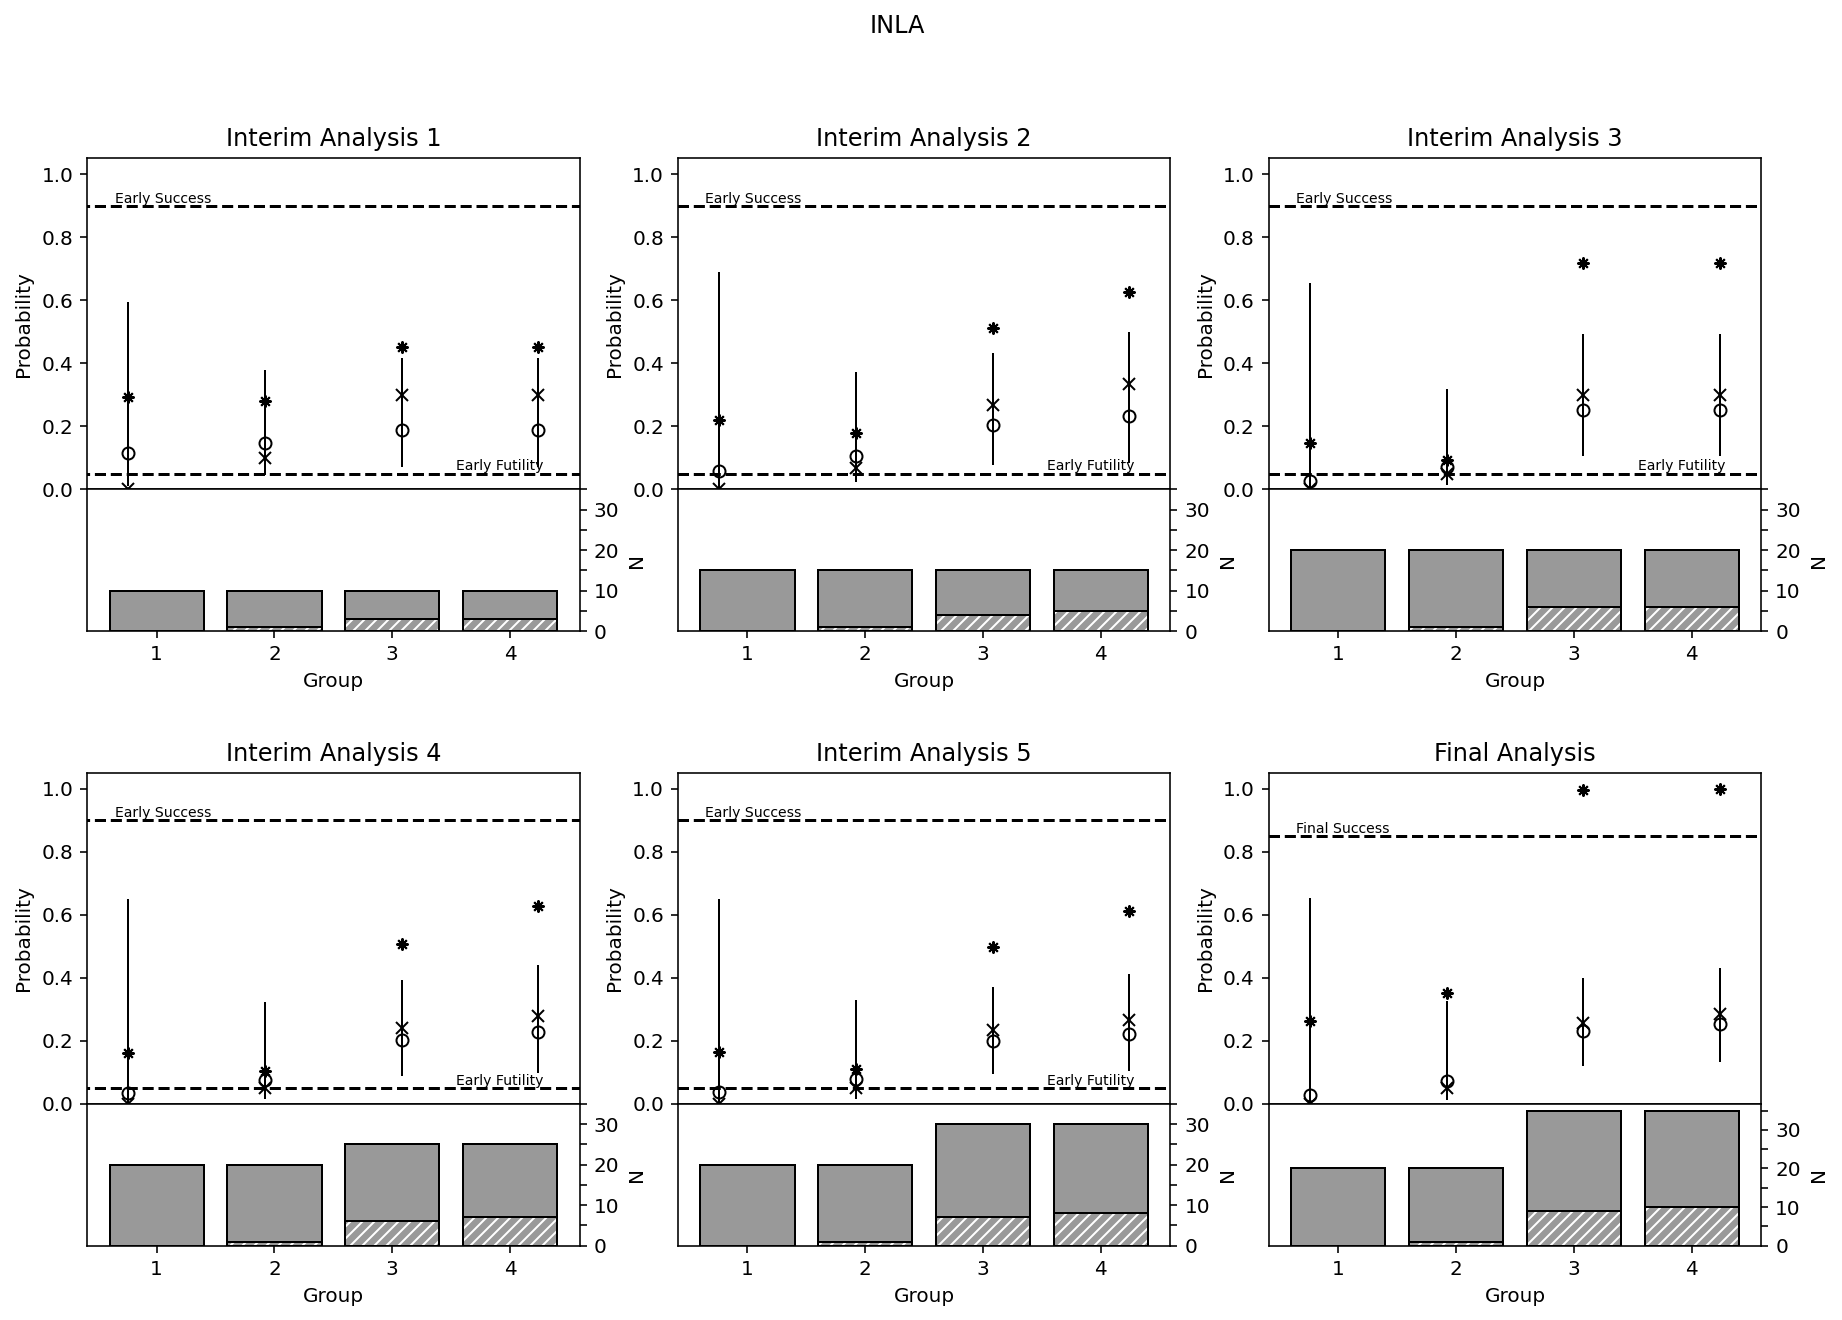

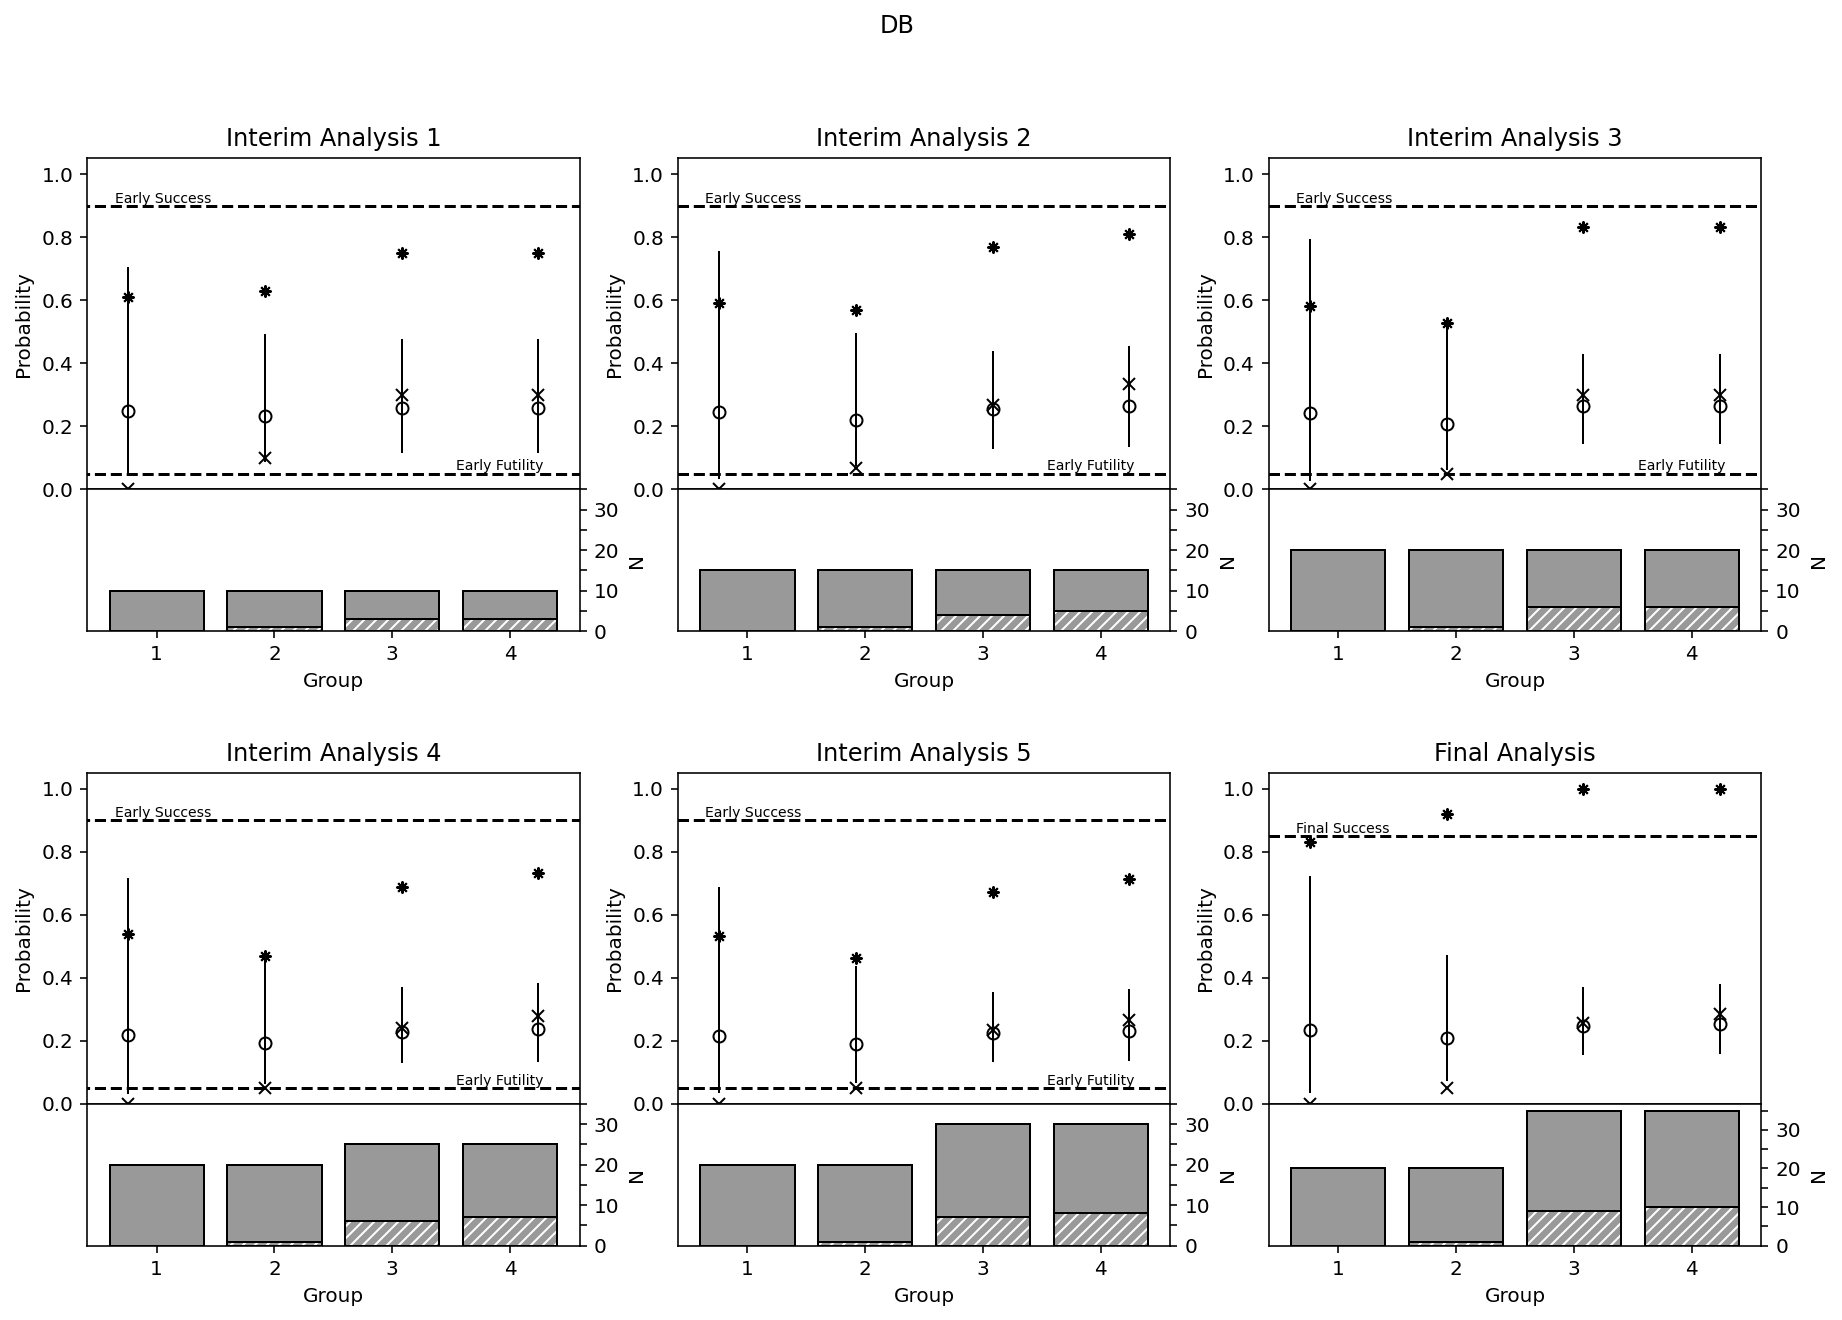

In [20]:
figure1_plot('INLA', data2, mu_inla2, sigma_inla2)
figure1_plot('DB', data2, mu_db2, sigma_db2)

### Skewness in the marginals

Why is the confidence interval on the 0-th arm in the figure above so large? This is a case where one of the core INLA assumptions breaks down. INLA assumes that p(x|y,\theta) is approximately normal. In this particular case, that assumption is not correct. Intuitively, with 0 successes out of 20 patients, there is a lot more potential for small $x_0$ values than potential for large $x_0$ values. As you can see below, there is substantial skewness. There are approaches to deal with this. See here: https://github.com/mikesklar/kevlar/issues/15

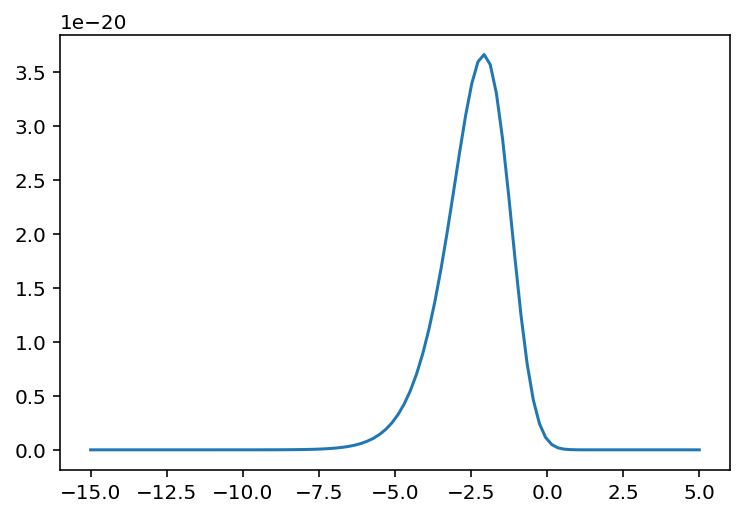

In [20]:
x0_vs = np.linspace(-15, 5, 100)
x123_vs = np.full_like(x0_vs, -1.0)
x = np.array([x0_vs, x123_vs, x123_vs, x123_vs]).T.copy()
lj = model.log_joint(model, x, data[0], np.array([[-1.0, 10.0]]))
plt.plot(x0_vs, np.exp(lj))
plt.show()

In [21]:
mu_post, sigma_post = inla.calc_posterior_x(post_theta2, report2)

# expit(mu_post) is the posterior estimate of the mean probability.
p_post = scipy.special.expit(mu_post)

# two sigma confidence intervals transformed from logit to probability space.
cilow = scipy.special.expit(mu_post - 2 * sigma_post)
cihigh = scipy.special.expit(mu_post + 2 * sigma_post)

In [22]:
cilow[0], cihigh[0]

(array([0.0111876 , 0.04650115, 0.07040077, 0.07040077]),
 array([0.59393357, 0.37904215, 0.41816045, 0.41816045]))

In [23]:
total_sum = np.sum(np.exp(lj))
mean = x0_vs[np.argmax(np.exp(lj))]
ci025 = x0_vs[np.argmax(np.cumsum(np.exp(lj)) / total_sum > 0.05)]
ci975 = x0_vs[np.argmax(np.cumsum(np.exp(lj)) / total_sum > 0.95)]
ci025, ci975, np.abs(mean-ci025), np.abs(mean-ci975), scipy.special.expit(ci025), scipy.special.expit(ci975)

(-4.292929292929292,
 -0.8585858585858581,
 2.2222222222222214,
 1.2121212121212128,
 0.013480627700845842,
 0.2976348849744225)

# Simulation

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload 
%autoreload 2

import scipy.stats
import numpy as np
import inla


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


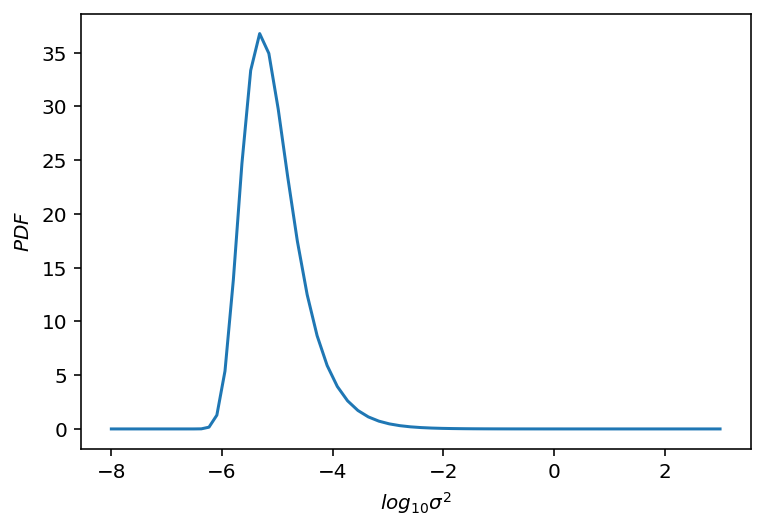

exact CDF:  0.00922569143991095
numerical integration CDF:  0.009225691439910979
error:  2.7755575615628914e-17


In [25]:

def log_gauss_rule(N, a, b):
    A = np.log(a)
    B = np.log(b)
    p, w = inla.gauss_rule(N, a=A, b=B)
    pexp = np.exp(p)
    wexp = np.exp(p) * w
    return (pexp, wexp)

a = 1e-8
b = 1e3
pexp, wexp = log_gauss_rule(90, a, b)
alpha = 0.0005
beta = 0.000005
f = scipy.stats.invgamma.pdf(pexp, alpha, scale=beta)
exact = scipy.stats.invgamma.cdf(b, alpha, scale=beta) - scipy.stats.invgamma.cdf(a, alpha, scale=beta)
est = np.sum(f * wexp)
plt.plot(np.log(pexp) / np.log(10), f)
plt.xlabel('$log_{10}\sigma^2$')
plt.ylabel('$PDF$')
plt.show()
print('exact CDF: ', exact),
print('numerical integration CDF: ', est)
print('error: ', est - exact)
sigma2_rule = (pexp, wexp)

In [26]:
p0 = np.array([0.05, 0.05, 0.1, 0.2]) # rate of response below this is the null hypothesis
p1 = np.array([0.2, 0.2, 0.3, 0.4]) # rate of response above this is the alternative hypothesis.
# p0 = np.array([0.1, 0.1, 0.1, 0.1]) # rate of response below this is the null hypothesis
# p1 = np.array([0.3, 0.3, 0.3, 0.3]) # rate of response above this is the alternative hypothesis.
# rate of response > p0 and < p1 is gray area.
p0_x = scipy.special.logit(p0)

pmid = (p0 + p1) / 2
pmid_x = scipy.special.logit(pmid)

 # final evaluation criterion 
 # accept the alternative hypo if Pr(p[i] > p0|data) > pfinal_thresh[i]
pfinal_thresh = np.array([0.82, 0.82, 0.85, 0.9])

# early stopping criteria
pmid_accept = 0.9
pmid_fail = 0.05

prior_mu_mean = scipy.special.logit(0.1)

def berry_prior(theta):
    mu = theta[..., 0]
    mu_prior = scipy.stats.norm.logpdf(mu, prior_mu_mean, 100)

    sigma2 = theta[..., 1]
    alpha = 0.0005
    beta = 0.000005
    sigma2_prior = scipy.stats.invgamma.logpdf(sigma2, alpha, scale=beta)
    return mu_prior + sigma2_prior

model = inla.binomial_hierarchical()
model.log_prior = berry_prior

In [27]:
%load_ext line_profiler

In [28]:
np.random.seed(1000)

def sim(n_sims, N, p):
    return np.stack(
        (scipy.stats.binom.rvs(N, p, size=(n_sims, 4)), np.full((n_sims, 4), N)), axis=2
    )

n_sims = 200

scenarios = {
    "Null": [0.05, 0.05, 0.1, 0.2],
    "Alternative": [0.2, 0.2, 0.3, 0.4],
    "One in the Middle": [0.2, 0.2, 0.2, 0.5],
    "All in the Middle": [0.15, 0.15, 0.2, 0.3],
    "One Nugget": [0.05, 0.05, 0.1, 0.4],
    "2 Null, 2 Alternative": [0.05, 0.05, 0.3, 0.4],
}

# Number of patients at the first look.
N_0 = 10

# Number of patients added per look.
deltaN = 5


In [29]:
results = dict()
n_looks = 6
for k in scenarios:
    results[k] = dict(
        data=[], mu_post=[], sigma_post=[], p_success=[], success_by_look=[]
    )
    p = scenarios[k]
    data = sim(n_sims, N_0, p)

    results[k]["data"] = []
    success = np.zeros((n_sims, 4), dtype=bool)
    stopping_time = np.full((n_sims, 4), -1, dtype=np.int32)
    for look in range(n_looks):
        results[k]["data"].append(data.copy())

        mu_rule = inla.gauss_rule(21, -5, 5)
        sigma2_rule = log_gauss_rule(21, 1e-7, 1e3)
        post_theta, report = inla.calc_posterior_theta(
            model, data, (mu_rule, sigma2_rule)
        )
        mu_post, sigma_post = inla.calc_posterior_x(post_theta, report)
        results[k]["mu_post"].append(mu_post)
        results[k]["sigma_post"].append(sigma_post)

        if look < 5:
            p_success = 1.0 - scipy.stats.norm.cdf(pmid_x, mu_post, sigma_post)
            stop_success = 0 * (p_success > pmid_accept) # no early stopping for success
            stop_fail = p_success < pmid_fail
        else:
            p_success = 1.0 - scipy.stats.norm.cdf(p0_x, mu_post, sigma_post)
            stop_success = p_success > pfinal_thresh[None, :]
            stop_fail = p_success <= pfinal_thresh[None, :]
        success[stop_success] = True
        stop = stop_success | stop_fail
        update_stopping = (stop & (stopping_time == -1)).astype(bool)
        stopping_time[update_stopping] = look

        results[k]["p_success"].append(p_success)
        results[k]["success_by_look"].append(stop_success)

        new_data = sim(n_sims, deltaN, p)
        data += new_data
    results[k]["success_by_look"] = np.array(results[k]["success_by_look"])
    results[k]['stopping_time'] = stopping_time
    results[k]['success'] = success

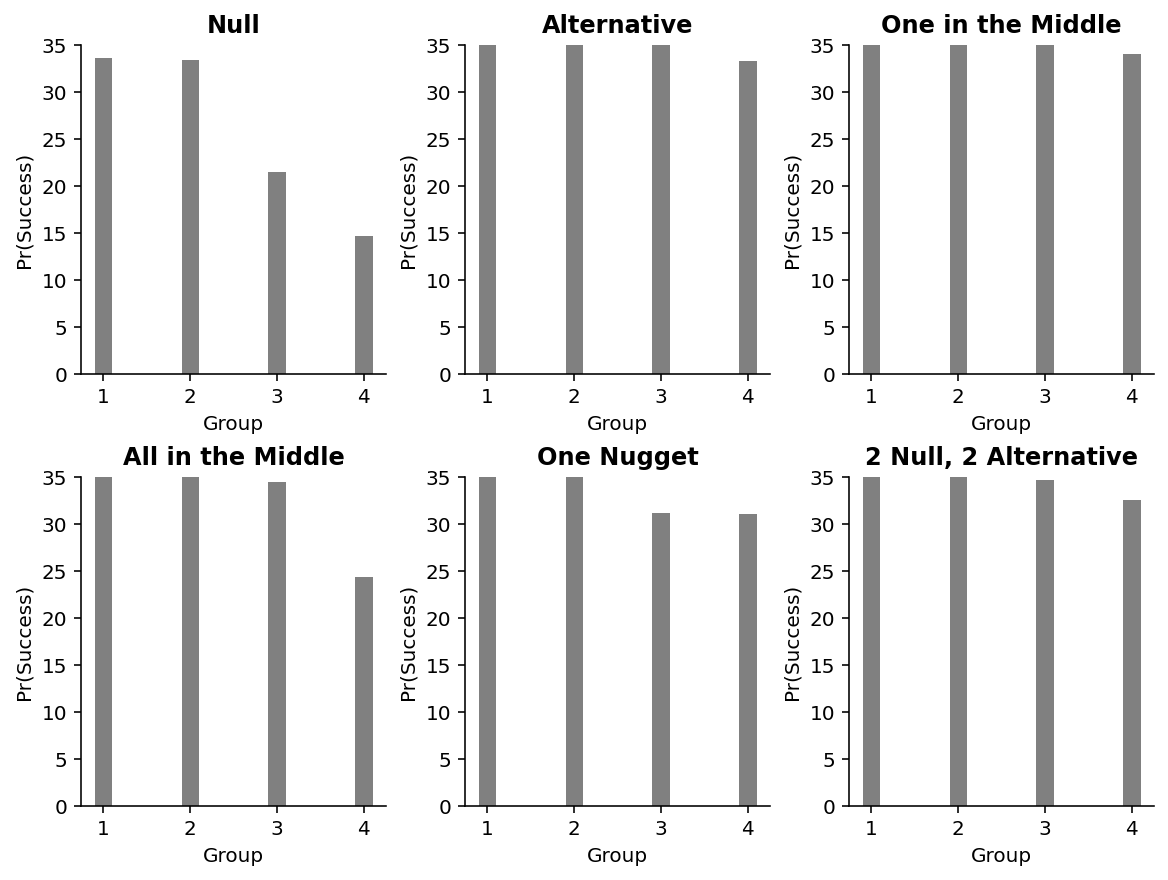

In [30]:
plt.figure(figsize=(8, 6), constrained_layout=True)
for i, k in enumerate(scenarios):
    sample_size = N_0 + results[k]['stopping_time'] * deltaN
    mean_sample_size = np.mean(sample_size, axis=0)

    plt.subplot(2, 3, 1 + i)
    plt.title(k, fontweight='bold')
    plt.bar(np.arange(4), mean_sample_size, 0.2, color='gray', )

    plt.ylim([0, 35])
    plt.yticks(np.arange(0, 36, 5))
    plt.ylabel('Pr(Success)')

    plt.xticks(np.arange(4), ['1', '2', '3', '4'])
    plt.xlabel('Group')

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
plt.show()

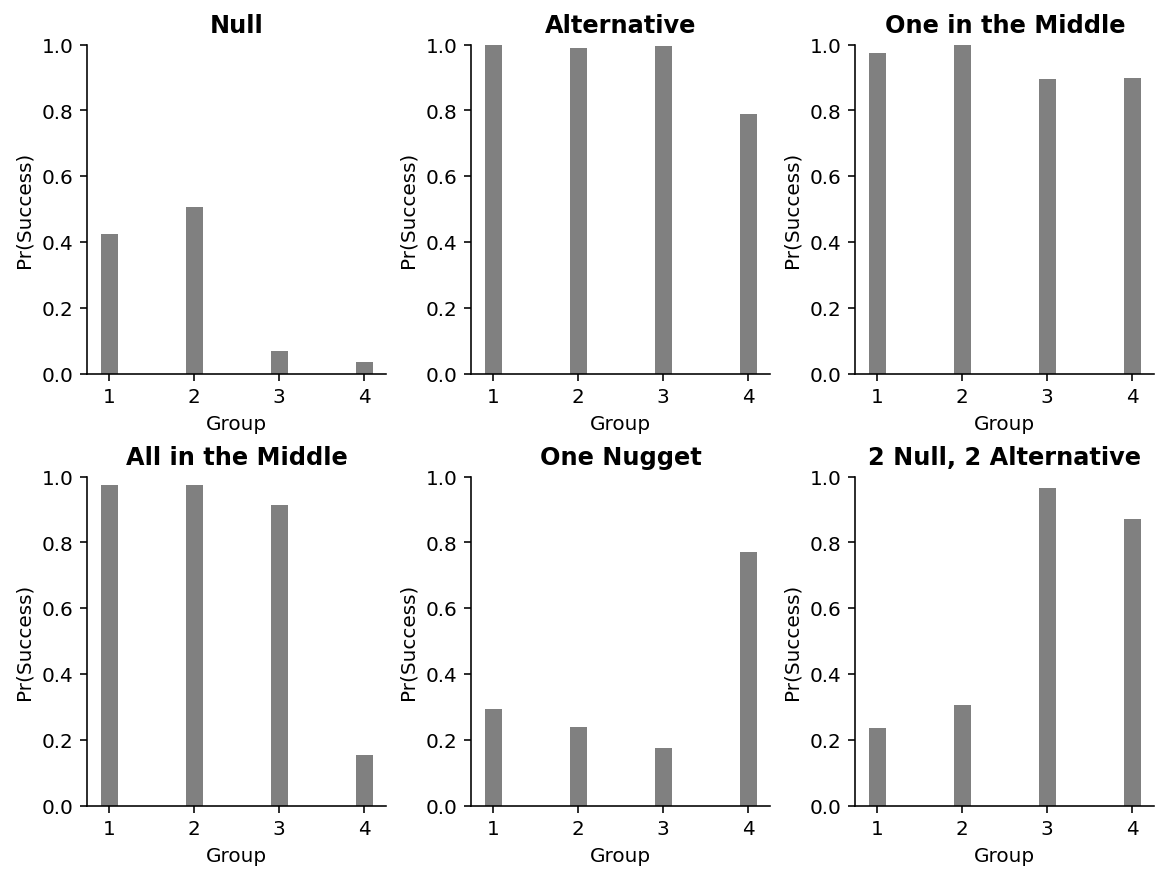

In [31]:
plt.figure(figsize=(8, 6), constrained_layout=True)
for i, k in enumerate(results):
    success = results[k]['success']
    n_sims = success.shape[0]
    success_rate = success.sum(axis=0) / n_sims
    plt.subplot(2, 3, 1 + i)
    plt.title(k, fontweight='bold')
    plt.bar(np.arange(4), success_rate, 0.2, color='gray', )

    plt.ylim([0, 1])
    plt.yticks(np.linspace(0, 1, 6))
    plt.ylabel('Pr(Success)')

    plt.xticks(np.arange(4), ['1', '2', '3', '4'])
    plt.xlabel('Group')

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)